# Rhyming score experiments

This notebook is for rhyming score experiments. HAMR 2016.

In [200]:
from __future__ import print_function, unicode_literals
import string

import nltk
import numpy

# For plotting outputs, we'll need
import matplotlib.pyplot as plt
# To display the plotted images inside the notebook:
%matplotlib inline
# Plotting the figures at a reasonable size
import matplotlib
matplotlib.rcParams['figure.figsize'] = (30.0, 20.0)

# Dirty, dirty trick
import rhyme
reload(rhyme)
from rhyme import *

In [126]:
cmudict = collections.defaultdict(list)
for word, syl in nltk.corpus.cmudict.entries():
    cmudict[word].append(syl)

In [127]:
bad_text = 'I see all I know all For i am the the oracle Give me your hand' \
    ' I see caked blood on concrete Dead bodies on grass' \
    ' Mothers crying seeing babies lowered caskets'
# bad_text = 'this thing does not rhyme even a little it is just normal text no rap'

good_text = 'Yeah, yeah It\'s the return of the Wild Style fashionist' \
' Smashin hits, make it hard to adapt to this Put pizazz and jazz in this, and cash in this' \
' Mastered this, flash this and make em clap to this DJ\'s throw on cuts and obey the crowd' \
' Just pump the volume up, and play it loud'
# good_text = 'take a step back hey really gonna hack a full stack in a day while on crack'

In [128]:
bad_words = tokenize(bad_text)
good_words = tokenize(good_text)

In [129]:
def pairwise_grid_stats(score_grid, words):
    minimum = score_grid[score_grid != -1.0].min()
    maximum = score_grid.max()
    print('Range: {0} -- {1}'.format(minimum, maximum))

def pairwise_rhyme_visualization(score_grid, words, show=True):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(score_grid, cmap=plt.cm.Blues)

    ax.set_xlim((0, len(words)))
    ax.set_ylim((0, len(words)))
    
    # put the major ticks at the middle of each cell
    ax.set_xticks(numpy.arange(score_grid.shape[0])+0.5, minor=False)
    ax.set_yticks(numpy.arange(score_grid.shape[1])+0.5, minor=False)

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    ax.set_xticklabels(words, minor=False)
    ax.set_yticklabels(words, minor=False)

    if show:
        plt.show()



In [130]:
def score_words(words, prondict=cmudict):
    score_grid = rhyme_score_grid(words, prondict=prondict)
    aggregate = aggregate_score(score_grid)
    return aggregate

def score_and_visualize_words(words, prondict=cmudict, **kwargs):
    score_grid = rhyme_score_grid(words, prondict=prondict, **kwargs)
    score = aggregate_score(score_grid)
    print('Score: {0:.4f}'.format(score))
    stats = pairwise_grid_stats(score_grid, words)
    pairwise_rhyme_visualization(score_grid, words)

In [131]:
#score_and_visualize_words(bad_words)

In [132]:
#score_and_visualize_words(good_words)

### Assessing the metric: baseline

To get some understanding of how this metric works, we need to find a baseline. Let's use some random sequences from the Brown corpus.

Obvious limit of the metric: at some point, we will randomly get a rhyming word anyway. Tackled by a sliding window of max. 16 words.

In [133]:
bt_reader = nltk.corpus.brown.words()
brown_tokens = [t for i, t in enumerate(bt_reader) if i < 10000]

In [134]:
bad_text_max_length = 50
n_bad_texts = 100
bad_texts = []
for i in xrange(n_bad_texts):
    # Choose a random start
    start = numpy.random.randint(low=0, high=len(brown_tokens) - bad_text_max_length - 1)
    text = brown_tokens[start:start + bad_text_max_length]
    bad_texts.append(' '.join(text))

In [135]:
bad_text_words = [tokenize(t) for t in bad_texts]
bad_text_scores = numpy.array([score_words(w) for w in bad_text_words[:100]])


In [136]:
#n, bins, patches = plt.hist(bad_text_scores, 10, normed=True)
#plt.show()

In [137]:
import codecs

def parse_artist(filename):
    with codecs.open(filename, 'r', 'utf-8') as hdl:
        lines = [l.strip() for l in hdl]
    
    texts = []
    current_text = []
    for l in lines:
        if len(l) == 0:
            texts.append(' '.join(current_text))
            current_text = []
        else:
            current_text.append(l)
    if len(current_text) > 0:
        texts.append(' '.join(current_text))
    
    return texts

rakim_texts = parse_artist('../examples_good_rhymes/rakim')
eminem_texts = parse_artist('../examples_good_rhymes/eminem')
aesop_texts = parse_artist('../examples_good_rhymes/aesop_rock')
lilwayne_texts = parse_artist('../examples_good_rhymes/lil_wayne')

In [138]:
good_texts = list(itertools.chain(rakim_texts, eminem_texts, aesop_texts, lilwayne_texts))
# print(len(good_texts))
good_text_words = [tokenize(t) for t in good_texts]

Score: 0.3104
Range: 0.0 -- 1.0


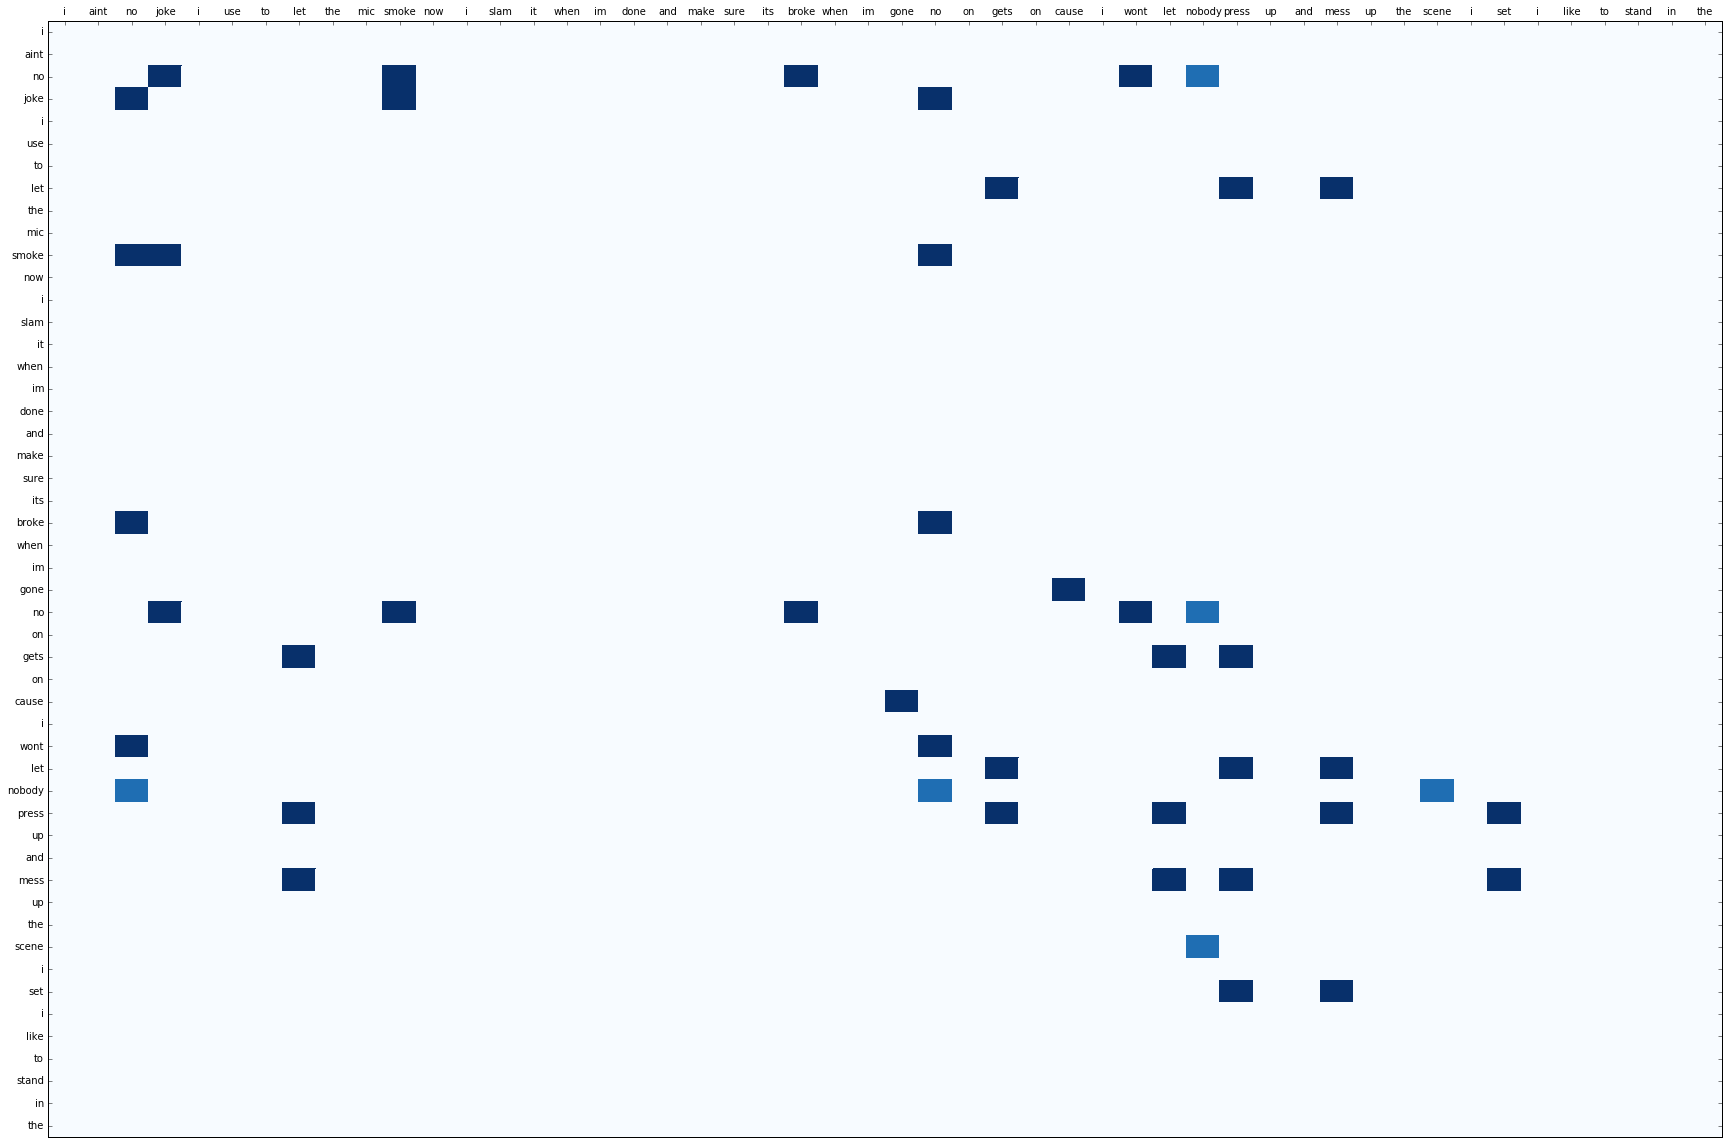

In [201]:
#good_text_scores = [score_words(w) for w in good_words]
score_and_visualize_words(good_text_words[0][:50], nonnegative=True)

Score: 0.3629
Range: 0.0 -- 0.90360200361


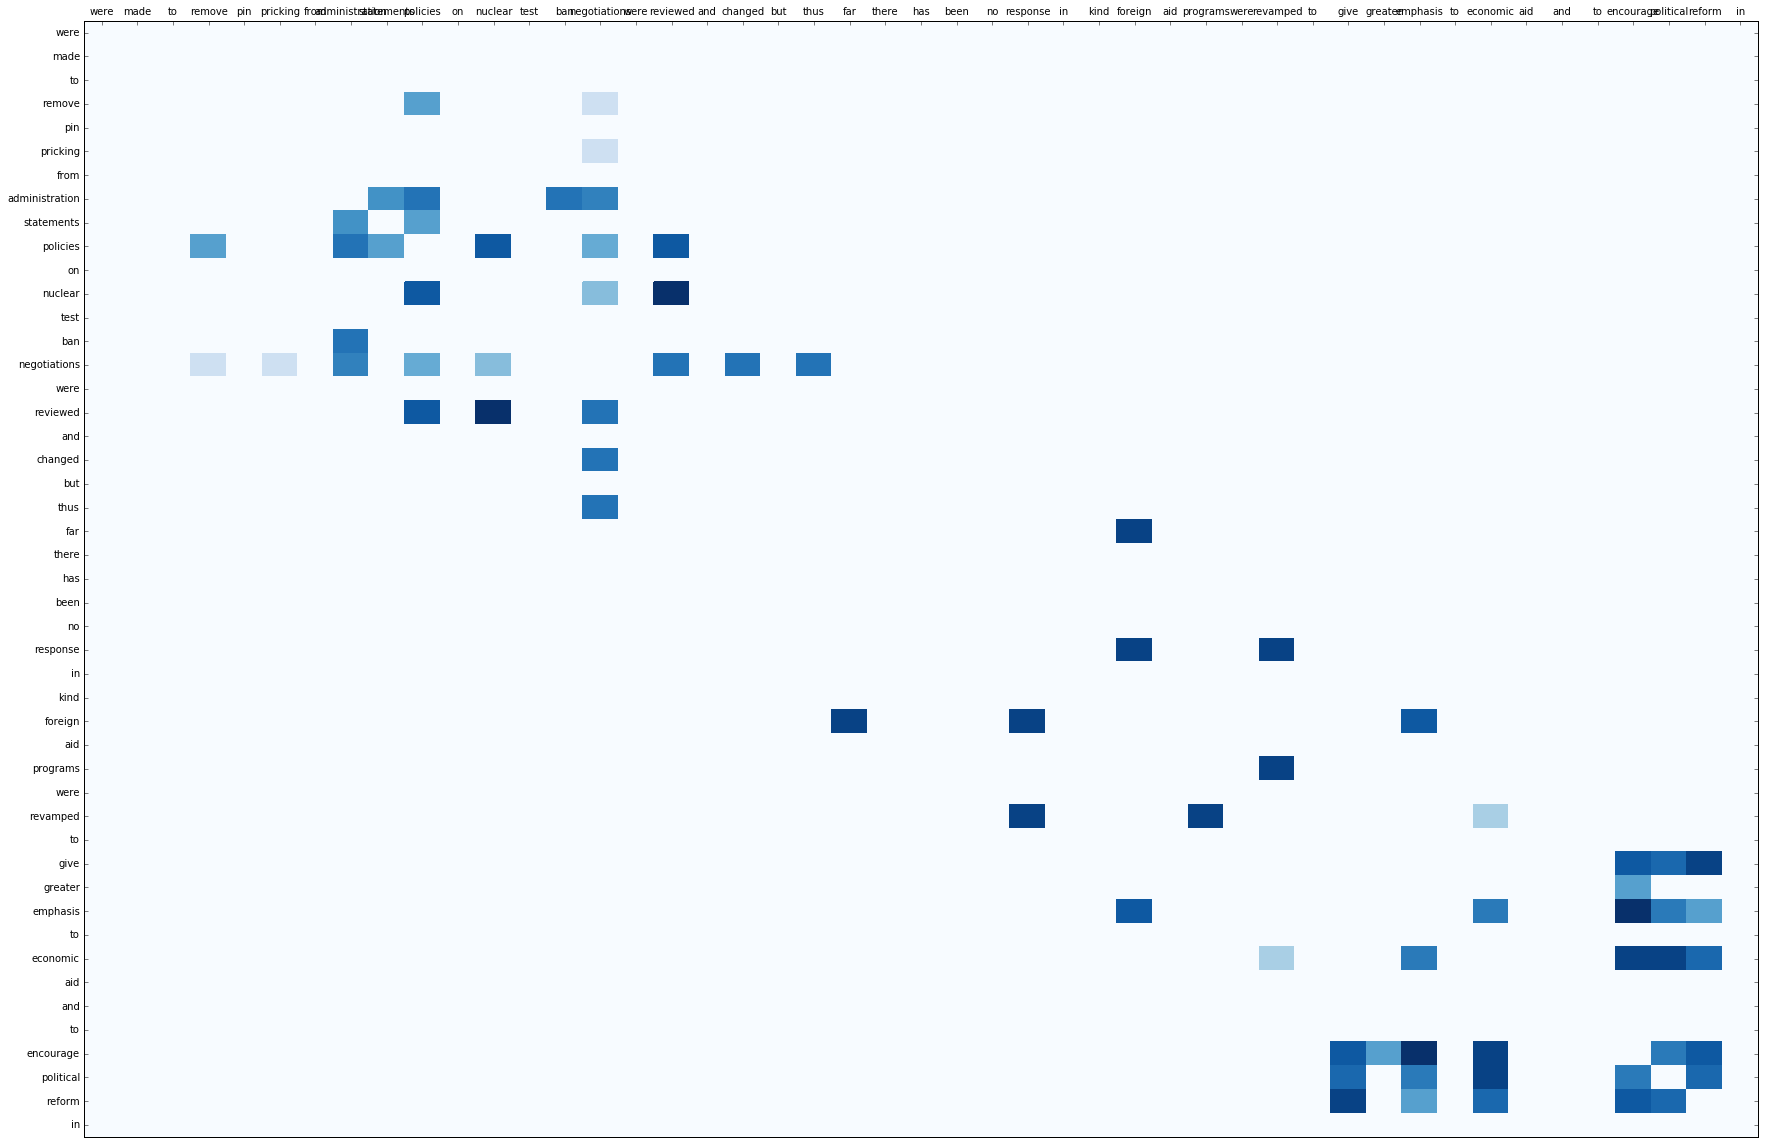

In [202]:
score_and_visualize_words(bad_text_words[2][:50], nonnegative=True)

In [141]:
# n, bins, patches = plt.hist(bad_text_scores, 10, normed=True)
# plt.show()
# _, _, _ = plt.hist(good_text_scores, bins=bins, color='r')
# plt.show()

In [194]:
reload(rhyme)
from rhyme import *

In [195]:
good_score_grid = rhyme_score_grid(good_text_words[0], prondict=cmudict)
bad_score_grid = rhyme_score_grid(bad_text_words[0], prondict=cmudict)

In [196]:
gw = good_text_words[0]
bw = bad_text_words[0]

print(len(bw))

45


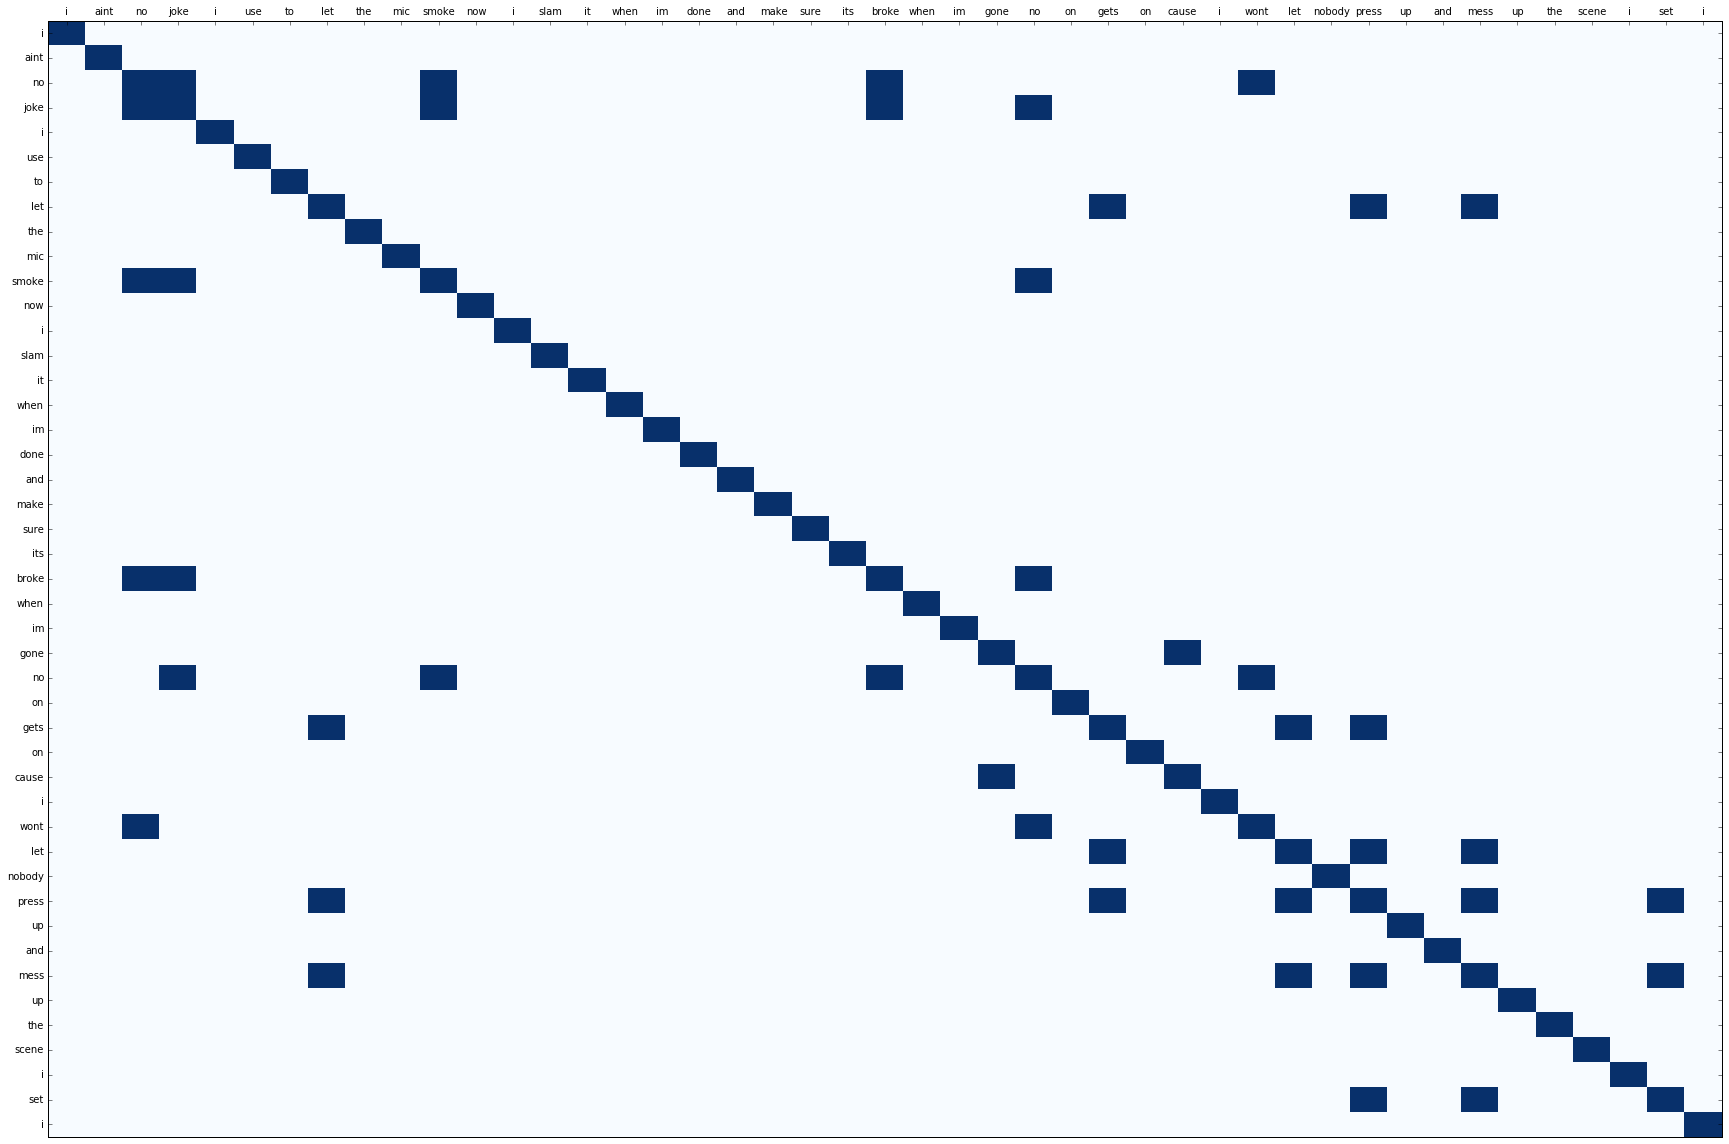

In [197]:
gsg = good_score_grid[:45,:45]
gw_part = gw[:45]
gsbg = binarize_grid(gsg)
pairwise_rhyme_visualization(gsbg, gw_part)

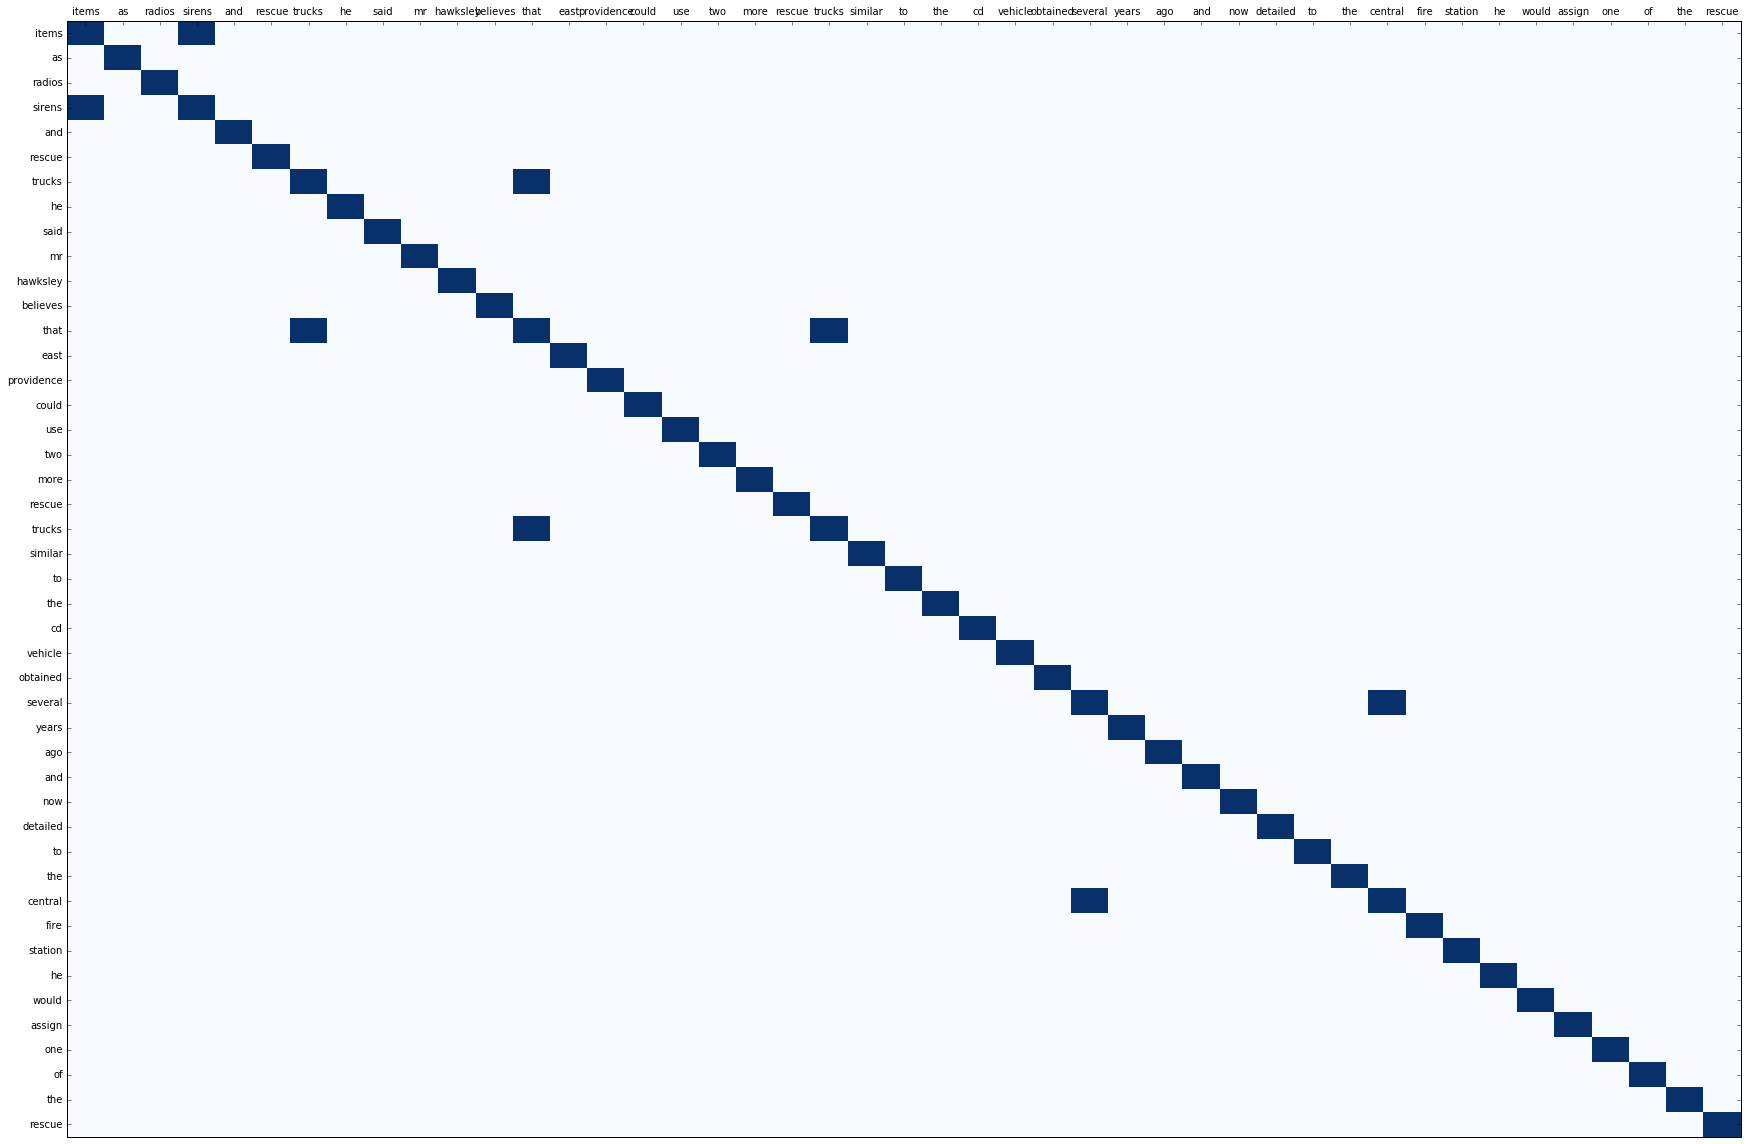

In [146]:
bsbg = binarize_grid(bad_score_grid)
pairwise_rhyme_visualization(bsbg, bw)

In [147]:
good_cliques = get_rhyme_groups(gsg, gw_part)
bad_cliques = get_rhyme_groups(good_score_grid, bw)

In [192]:
import pprint

good_graph = get_rhyme_graph(gsg, gw_part)
bad_graph = get_rhyme_graph(bad_score_grid, bw)

In [193]:
g_components = list(networkx.algorithms.connected.connected_components(good_graph))
g_nontrivial = [g for g in g_components if len(g) >= 2]
print(' '.join(gw_part))
pprint.pprint(g_nontrivial)

i aint no joke i use to let the mic smoke now i slam it when im done and make sure its broke when im gone no on gets on cause i wont let nobody press up and mess up the scene i set i
[set([u'gets_28', u'let_33', u'let_7', u'mess_38', u'press_35', u'set_43']),
 set([u'broke_22', u'no_2', u'no_26', u'smoke_10', u'wont_32']),
 set([u'cause_30', u'gone_25'])]


In [110]:
def nontrivial_components(G):
    b_components = list(networkx.algorithms.connected.connected_components(G))
    b_nontrivial = [g for g in b_components if len(g) >= 2]
    pprint.pprint(b_nontrivial)

In [90]:
def triangle_analysis(G):
    t = networkx.algorithms.cluster.triangles(G)
    print('Triangles: {0}'.format({k: v for k, v in t.iteritems() if v >= 1}))
    print(networkx.algorithms.cluster.average_clustering(G))
    
triangle_analysis(good_graph)
triangle_analysis(bad_graph)

Triangles: {u'let_33': 2, u'gets_28': 2, u'press_35': 5, u'set_43': 1, u'mess_38': 3, u'let_7': 2}
0.0785185185185
Triangles: {}
0.0


In [84]:
def clique_analysis(cliques):
    multi_cliques = [c for c in cliques if len(c) > 3]
    multi_clique_ratio = float(len(multi_cliques)) / len(cliques)
    cliques_by_level = collections.defaultdict(list)
    for c in cliques:
        cliques_by_level[len(c)].append(set([w.split('_')[0] for w in c]))
    print(multi_clique_ratio)
    pprint.pprint({k: len(v) for k, v in cliques_by_level.iteritems()})
    
    if 3 in cliques_by_level:
        pprint.pprint(cliques_by_level[3])
        if 4 in cliques_by_level:
            pprint.pprint(cliques_by_level[4])
    else:
        print('No cliques above 2 members')
        
    return cliques_by_level


In [86]:
gcbl = clique_analysis(good_cliques)
bcbl = clique_analysis(bad_cliques)
print('-----------------')

g_overlap = find_overlapping_cliques(gcbl[3])
pprint.pprint(g_overlap)
print('---------------')
b_overlap = find_overlapping_cliques(bcbl[3])
pprint.pprint(b_overlap)

0.0
{1: 45, 2: 21, 3: 5}
[set([u'gets', u'let', u'press']),
 set([u'let', u'mess', u'press']),
 set([u'gets', u'let', u'press']),
 set([u'mess', u'press', u'set']),
 set([u'let', u'mess', u'press'])]
0.0
{1: 45, 2: 21, 3: 5}
[set([u'as', u'principal', u'state']),
 set([u'as', u'principal']),
 set([u'as', u'has', u'principal']),
 set([u'a', u'as', u'state']),
 set([u'a', u'as', u'has'])]
-----------------
[set([u'gets', u'let', u'press']),
 set([u'let', u'mess', u'press']),
 set([u'mess', u'press', u'set'])]
---------------
[set([u'as', u'principal', u'state']),
 set([u'as', u'principal']),
 set([u'as', u'has', u'principal']),
 set([u'a', u'as', u'state']),
 set([u'a', u'as', u'has'])]


In [120]:
reload(rhyme)
from rhyme import *

In [121]:
other_gw = good_text_words[-1][:45]
other_good_score_grid = rhyme_score_grid(other_gw, prondict=cmudict)

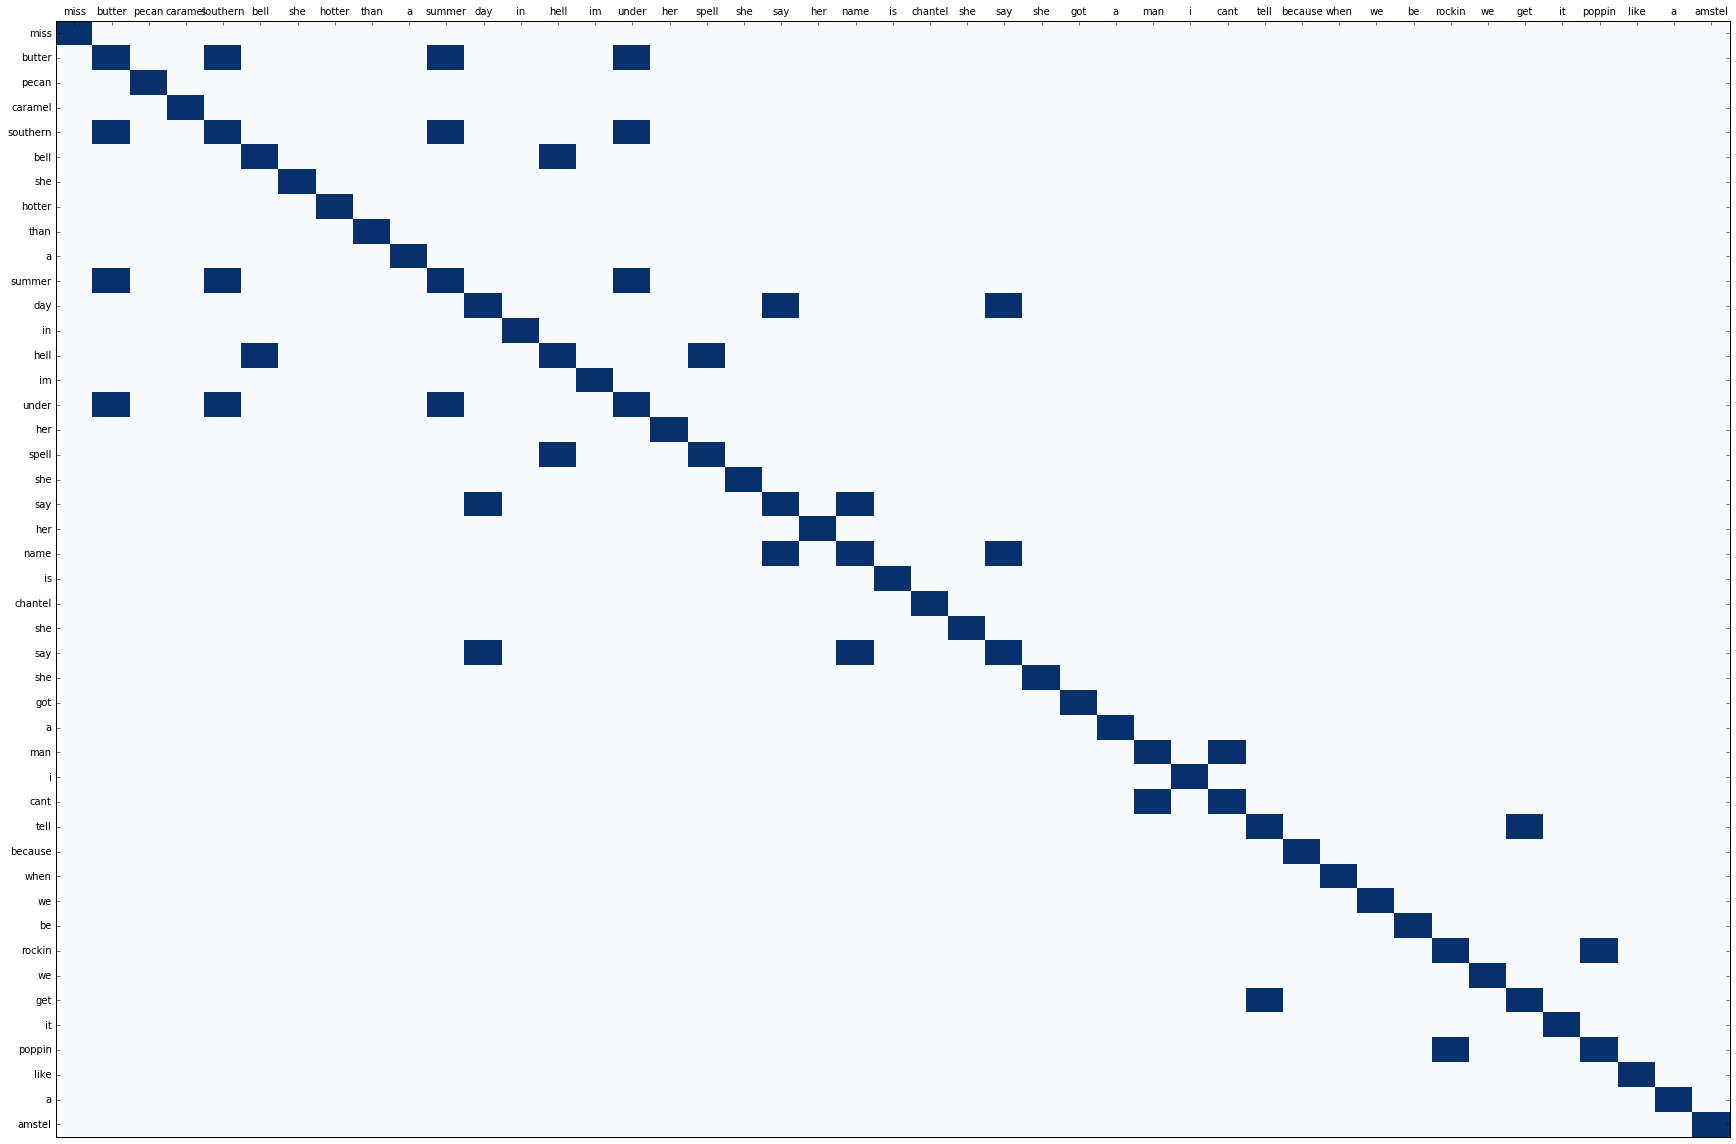

In [122]:
ogsbg = binarize_grid(other_good_score_grid)
pairwise_rhyme_visualization(ogsbg, other_gw)


In [123]:
ograph = get_rhyme_graph(other_good_score_grid, other_gw)
triangle_analysis(ograph)
nontrivial_components(ograph)

Triangles: {u'under_15': 3, u'summer_10': 3, u'butter_1': 3, u'southern_4': 3}
0.0888888888889
[set([u'day_11', u'name_21', u'say_19', u'say_25']),
 set([u'butter_1', u'southern_4', u'summer_10', u'under_15']),
 set([u'poppin_41', u'rockin_37']),
 set([u'cant_31', u'man_29']),
 set([u'bell_5', u'hell_13', u'spell_17']),
 set([u'get_39', u'tell_32'])]


In [124]:
k_cliques = list(networkx.k_clique_communities(ograph, 2))
print(k_cliques)

[frozenset([u'say_19', u'say_25', u'name_21', u'day_11']), frozenset([u'bell_5', u'spell_17', u'hell_13']), frozenset([u'under_15', u'summer_10', u'butter_1', u'southern_4']), frozenset([u'cant_31', u'man_29']), frozenset([u'rockin_37', u'poppin_41']), frozenset([u'tell_32', u'get_39'])]


### Ideas on improving

* Disambiguate the indefinite article.
* Remove stopwords (count them as -1). Implemented as "weak" stopwords (if the other word is not a weak stopword, count normally) vs. "strong" (if one of the words is a strong stopword, the pair gets -1)
* Only count words within a relevant window (improves on randomness)
* Only retain nouns, verbs, adjectives and adverbs. (NOT IMPLEMENTED)
* Word count patterns: 